--- In this example we look at the properties of one of the sources identified by segmentation.

In [1]:
import numpy as np
from astropy.io import fits

In [2]:
image_dir = 'data' # define image directory relative to this script

In [3]:
f = 'f125w' # filter

In [4]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [5]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [6]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [7]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [8]:
noise = 1./np.sqrt(wht) # conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image.

In [9]:
from photutils import detect_sources
import matplotlib.pyplot as plt

In [10]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [11]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

---

In [12]:
unique, counts = np.unique(segm.data, return_counts=True)

In [13]:
print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[37929    18    12    54    23     5   235   707   199   318    12   147
    49    30    84    36    49    11    53    24     5]


--- let's now plot the segmentation map but only for a single source

segm.data is the segmentation map. In this map pixels are labelled as either "0" if they are part of the background (i.e. not associated with a source) or >0 if they belong to a source. Each discrete object has a different number.

i = 11 # this corresponds to the 11th object NOT the 12th. The 0 (zero) index corresponds to the background. The choice of object 11 is completely arbitrary.

In [14]:
import random
i = random.randint(1, segm.nlabels) # choose a random object
#eg:
i = 11

In [15]:
masked_segm = np.ma.masked_where(segm.data != i, segm) # mask all pixels except object i

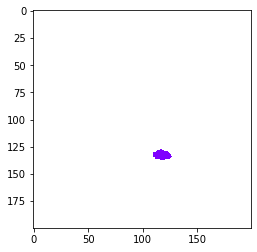

In [16]:
plt.imshow(masked_segm, cmap = 'rainbow') # plot masked segmentation map
plt.show()

--- let's now plot the science (flux) map but only for the same single source

In [17]:
masked_sci = np.ma.masked_where(segm.data != i, sci)

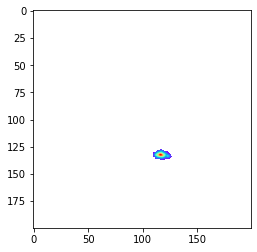

In [18]:
plt.imshow(masked_sci, cmap = 'rainbow') # plot masked segmentation map
plt.show()

--- instead of plotting the entire image we can plot a zoom in of the object we want. To do this we can use the slice provided by segmentation object

In [19]:
slices = segm.slices[i-1] # a pair of python slice objects NOTE: the -1 is necessary as slices are only provided for objects not the background. The first object would be segm.slices[0] NOT segm.slices[1] because of python indexing convention. BE CAREFUL.

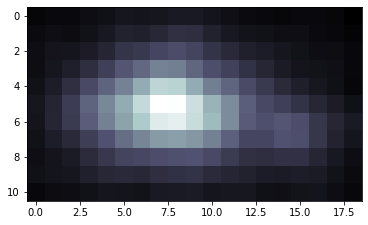

In [20]:
plt.imshow(sci[slices], cmap = 'bone') # apply slice to science image
plt.show()

--- now lets determine the total flux of that same source by simply summing the pixels

we could simply sum the masked science image (masked_sci):

In [21]:
print(f'signal using masked science image: {np.sum(masked_sci)}')

signal using masked science image: 1.711333990097046


or, avoiding previous steps only sum pixels on the orginal science image where the segmentation map = the index of our target galaxy:

In [22]:
print(f'signal using science image + np.where command on segmentation map: {np.sum(sci[np.where(segm.data==i)])}')

signal using science image + np.where command on segmentation map: 1.711333990097046
